In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import diffrax as dfx
import optax
import numpy as np 
import matplotlib.pyplot as plt
from chainconsumer import Chain, ChainConsumer

from configs import make_dirs
from configs.shear import shear
from data.shear import get_shear_experiment, get_experiment_data
from sbiax.ndes import Ensemble
from sbiax.utils import make_df
from sbiax.ndes import CNF, Scaler
from sbiax.train import train_ensemble
from sbiax.compression.linear import _mle
from sbiax.inference.nle import blackjax_sample

/Users/Jed.Homer/phd/sbiax/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = shear()

key = jr.key(config.seed)
key, model_key, train_key, sample_key = jr.split(key, 4)

In [3]:
# Location of results / saving
results_dir  = (
    "/Users/Jed.Homer/phd/sbiax/results/" +  # Import this from a constants file
    f"{config.sbi_type}/" + 
    f"{config.exp_name}/" + 
    f"{config.model.model_type}/" + 
    f"{config.seed}/"
)
make_dirs(results_dir)

RESULTS_DIR:
 /Users/Jed.Homer/phd/sbiax/results/nle/shear/cnf/0/


In [4]:
(
    alpha,
    parameter_names,
    mu,
    covariance,
    precision,
    dmu,
    F,
    Finv, 
    lower,
    upper
) = get_shear_experiment()

(
    X, 
    Y, 
    covariance_est, 
    Finv_est,
    precision_est,
    parameter_prior
) = get_experiment_data(
    key=key,
    good=True,
    n_sims=config.n_linear_sims,
    n_obs=1,
    results_dir=results_dir
)

# Compression function
s = lambda d, p: _mle(
    d,
    pi=p,
    Finv=Finv, 
    mu=mu + jnp.dot(p - alpha, dmu), 
    dmu=dmu, 
    precision=precision
)

In [5]:
# Build neural density estimators
model_keys = jr.split(model_key, 2)

scaler = Scaler(X, Y, use_scaling=config.model.use_scaling)

solver = getattr(dfx, config.model.solver)()

ndes = [
    CNF(
        event_dim=alpha.size, 
        context_dim=alpha.size, 
        width_size=config.model.width_size,
        depth=config.model.depth, 
        solver=solver,
        activation=config.model.activation,
        dt=config.model.dt, 
        t1=config.model.t1, 
        dropout_rate=config.model.dropout_rate,
        exact_log_prob=config.model.exact_log_prob,
        scaler=scaler,
        key=key
    )
    for key in model_keys
]

ensemble = Ensemble(ndes, sbi_type=config.sbi_type)

In [6]:
opt = getattr(optax, config.opt)(config.lr)

ensemble, stats = train_ensemble(
    train_key, 
    ensemble,
    train_mode=config.sbi_type,
    train_data=[X, Y], 
    opt=opt,
    n_batch=config.n_batch,
    patience=config.patience,
    n_epochs=config.n_epochs,
    results_dir=results_dir
)

NDE has n_params=51.


Training:  13%|█▎        | 1316/10000 [02:08<14:08, 10.23epoch/s, train=-7.282E+00, valid=-7.178E+00, best_valid=-7.278E+00, stop=0000]


Training terminated early at epoch 1317; valid=-7.178E+00, train=-7.282E+00.
NDE has n_params=51.


Training:  17%|█▋        | 1653/10000 [02:37<13:16, 10.48epoch/s, train=-8.317E+00, valid=-8.396E+00, best_valid=-8.419E+00, stop=0000]


Training terminated early at epoch 1654; valid=-8.396E+00, train=-8.317E+00.
Weights: [0.24061398 0.759386  ]


In [7]:
# Get a noisy datavector with different alpha parameters
key_prior, key_state, key_sample = jr.split(sample_key, 3)

# Generates datavector d ~ G[d|xi[pi], Sigma]
datavector = jr.multivariate_normal(key, mu, covariance)

# Linear summary
X_ = s(datavector, alpha)

# Initial state of MCMC walkers
state = jr.multivariate_normal(
    key_state, X_, Finv, (2 * config.n_walkers,)
)

ensemble = eqx.nn.inference_mode(ensemble)

log_prob_fn = ensemble.ensemble_log_prob_fn(X_, parameter_prior)

In [12]:
samples, samples_log_prob = blackjax_sample(
    key_sample, log_prob_fn, prior=parameter_prior
)

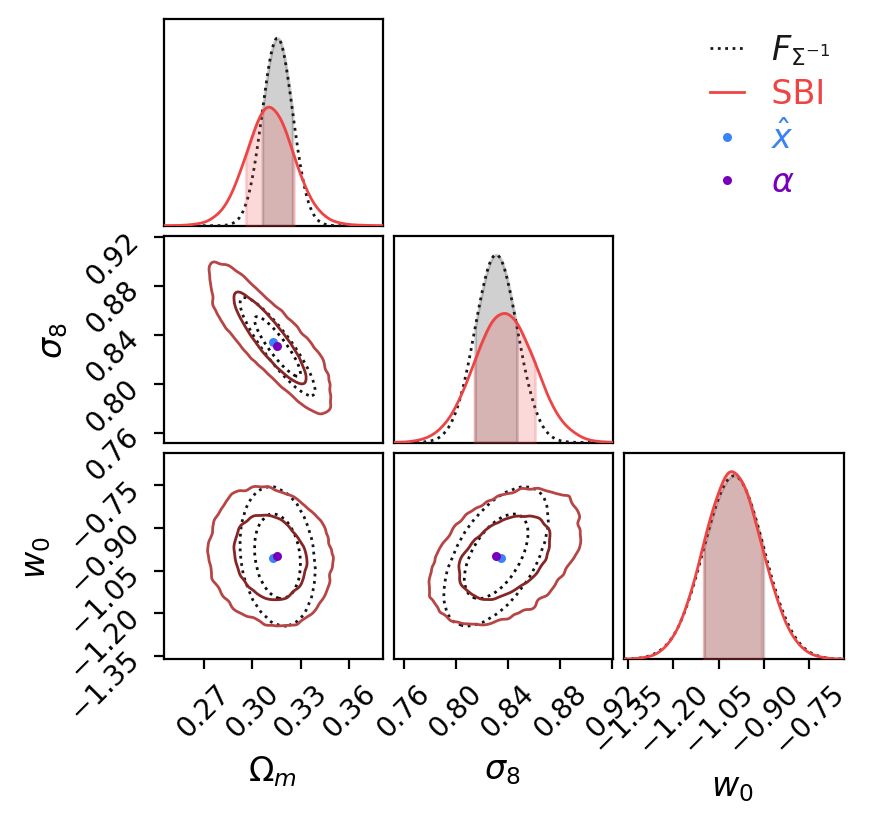

In [14]:
posterior_df = make_df(samples, samples_log_prob, parameter_names)

c = ChainConsumer()
c.add_chain(
    Chain.from_covariance(
        alpha,
        Finv,
        columns=parameter_names,
        name=r"$F_{\Sigma^{-1}}$",
        color="k",
        linestyle=":",
        shade_alpha=0.
    )
)
c.add_chain(Chain(samples=posterior_df, name="SBI", color="r", shade_alpha=0.))
c.add_marker(
    location=dict(zip(parameter_names, np.asarray(X_))), name=r"$\hat{x}$", color="b"
)
c.add_marker(
    location=dict(zip(parameter_names, np.asarray(alpha))), name=r"$\alpha$", color="#7600bc"
)
fig = c.plotter.plot()
fig.set_dpi(200)
fig.set_figheight(4.)
fig.set_figwidth(4.)
plt.show()